In [2]:
# Import libraries

import torch
import numpy as np
import matplotlib.pyplot as plt

# Pytorch dataset

from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Pytorch model

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [31]:
# Helper functions

def imshow(img):
  img = img/2 + 0.5 # Un-normalizing 
  plt.imshow(np.transpose(img,(1,2,0)))

# A function to display images of the training data

def display_batch_images(images):
  
  fig = plt.figure(figsize=(20,4))

  # Displaying the 20 images

  for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# A function to display images of model prediction

def display_batch_test_images(preds,images,classes):

  fig = plt.figure(figsize=(25,4))
    
  for idx in range(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title(
        '{} ({})'.format(
        classes[preds[idx]],
        classes[labels[idx]]
    ),
    color=("green" if preds[idx] == labels[idx] else "red")
    )

In [4]:
# Checking if a GPU is available using CUDA

train_on_gpu = torch.cuda.is_available()

if train_on_gpu: print('Training on GPU...')
else: print('Training on CPU...')

Training on GPU...


In [5]:
# Data transforming to tensor and normalizing it

# Data augmentation for the training set 

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [6]:
# Downloading the data based on the transformation listed above

train_data = datasets.CIFAR10(
    'CIFAR10/',
    train=True,
    download=True,
    transform=train_transform
    )
test_data = datasets.CIFAR10(
    'CIFAR10/',
    train=False,
    download=True,
    transform=test_transform
    )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


In [7]:
# Initializing some parameters for the training and modeling

batch_size = 20

validation_size = 0.2

In [8]:
# Creating indices for train and validation split

indices = list(range(len(train_data)))
split = int(np.floor(validation_size*len(train_data)))
np.random.shuffle(indices)
train_idx , valid_idx = indices[split:],indices[:split]

In [9]:
# Defining samplers for getting the training and validation data

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [10]:
# Preparing the data loader

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    sampler = train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    sampler = valid_sampler
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size
)

In [11]:
# Specifying all the 10 classes

classes = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
    ]

In [12]:
# Obtaining batch of training images

images,labels = next(iter(train_loader))
images = images.numpy()
images.shape

(20, 3, 32, 32)

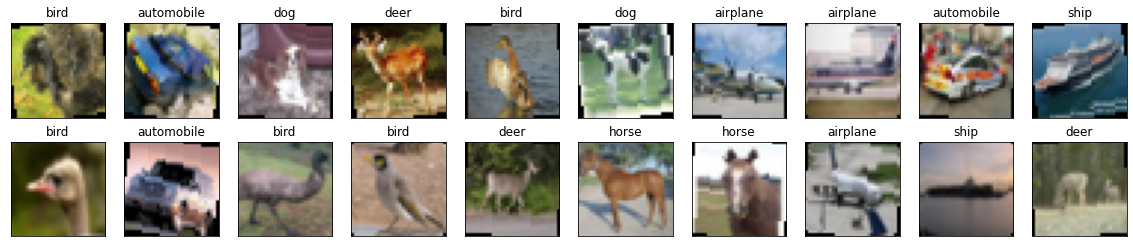

In [13]:
# Plotting the images in a batch

display_batch_images(images)


In [14]:
# Model defination

''' 
We will have 3 convolutional layers,
dropout and one fully connected layer 

'''

class Net(nn.Module):

  def __init__(self):
    super(Net,self).__init__()

    # A conv layer of input channel 3 kernel size 3 and 
    # output channel of 16 and padding 1 
    # yielding an image of shape (i,i,16)

    self.conv1 = nn.Conv2d(3,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)

    # Max pool yields a shape of (i/2,i/2,channel)

    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*4*4,500)
    self.fc2 = nn.Linear(500,10)
    self.dropout = nn.Dropout(0.25)


  def forward(self,x):

    # Applying Relu to all the conv outputs and max pooling

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # After the max pooling and the Conv layers we get an image of
    # size (batch_size,4,4,64)

    # We will flatten it to feed to our fully connected layer

    x = x.view(-1,64*4*4)

    # Add a dropout layer for case of overfitting

    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    
    # At last we get shape of (batch_size,10)
    x = self.fc2(x)

    return x

In [15]:
# Instantiating the model

model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [16]:
# Check if any GPU is available and moving the model

if train_on_gpu:
  model.cuda()

In [17]:
# Initializing loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [18]:
# Specifiying the epoch 

n_epochs = 30

# Initializing the validation loss to a bigger number for trackin our model

valid_loss_min = np.Inf


for epoch in range(1,n_epochs+1):

  # Tracking train and valid losses

  train_loss = 0.0
  valid_loss = 0.0

  ######################
  # Training the Model #
  ######################
  model.train()
  for data,target in train_loader:

    # Check if GPU is available and shifting to that

    if train_on_gpu:
      data,target = data.cuda(),target.cuda()

    # Cleaning the optimizer cache    
    optimizer.zero_grad()
    # Forward pass
    output = model(data)
    # Calculating the loss
    loss = criterion(output,target)
    # Backward propagation and updating weights
    loss.backward()
    optimizer.step()
    # Updating training loss
    train_loss += loss.item()*data.size(0)

  ######################
  # Validating the Model #
  ######################
  model.eval()
  for data,target in valid_loader:

    if train_on_gpu:
      data,target = data.cuda(),target.cuda()

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    valid_loss += loss.item()*data.size(0)

  # Calculating average losses
  
  train_loss_tot = train_loss / len(train_loader.sampler)
  valid_loss_tot = valid_loss / len(valid_loader.sampler)

  print('Epoch: {} \t Training loss: {:.5f} \t Validation_loss:{:.5f}'.format(
      epoch,
      train_loss_tot,
      valid_loss_tot
  ))

  #########################
  # Saving the best model #
  #########################

  if valid_loss_tot < valid_loss_min:

    print('Validation loss decreased {:.5f} -> {:.5f} Saving the model....'
    .format(
        valid_loss_min,
        valid_loss_tot
    ))
    torch.save(model.state_dict(),'model_cifar.pt')
    valid_loss_min = valid_loss_tot

Epoch: 1 	 Training loss: 2.10933 	 Validation_loss:1.76914
Validation loss decreased inf -> 1.76914 Saving the model....
Epoch: 2 	 Training loss: 1.61833 	 Validation_loss:1.48910
Validation loss decreased 1.76914 -> 1.48910 Saving the model....
Epoch: 3 	 Training loss: 1.45289 	 Validation_loss:1.35402
Validation loss decreased 1.48910 -> 1.35402 Saving the model....
Epoch: 4 	 Training loss: 1.34403 	 Validation_loss:1.24783
Validation loss decreased 1.35402 -> 1.24783 Saving the model....
Epoch: 5 	 Training loss: 1.25465 	 Validation_loss:1.15267
Validation loss decreased 1.24783 -> 1.15267 Saving the model....
Epoch: 6 	 Training loss: 1.17824 	 Validation_loss:1.06723
Validation loss decreased 1.15267 -> 1.06723 Saving the model....
Epoch: 7 	 Training loss: 1.11026 	 Validation_loss:1.00545
Validation loss decreased 1.06723 -> 1.00545 Saving the model....
Epoch: 8 	 Training loss: 1.05383 	 Validation_loss:0.94519
Validation loss decreased 1.00545 -> 0.94519 Saving the model.

In [19]:
# Loading the model with the lowest validation loss

model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [24]:
# Testing the model

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data,target in valid_loader:

    if train_on_gpu:
      data,target = data.cuda(),target.cuda()

    output = model(data)
    loss = criterion(output,target)

    test_loss += loss.item()*data.size(0)

    _,pred = torch.max(output,1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    if train_on_gpu: correct = np.squeeze(correct_tensor.cpu().numpy()) 
    else: correct = np.squeeze(correct_tensor.numpy())

    for i in range(batch_size):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset) 
print('Test loss {:.5f} \n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0 :
    print('Test accuracy of %s: %2d%% (%2d/%2d)' % (
        classes[i],
        100*(class_correct[i]/class_total[i]),
        np.sum(class_correct[i]),
        np.sum(class_total[i])
    ))

  else:
    print('Test accuracy of {} is N/A ( No examples found )'.format(
        classes[i]
    ))

print('\n Overall test accuracy is: %2d%% or %2d/%2d' % (
    100*(np.sum(class_correct)/np.sum(class_total)),
    np.sum(class_correct),
    np.sum(class_total)
))

Test loss 0.39276 

Test accuracy of airplane: 88% (899/1015)
Test accuracy of automobile: 93% (938/1004)
Test accuracy of bird: 79% (798/1001)
Test accuracy of cat: 74% (763/1020)
Test accuracy of deer: 86% (868/1004)
Test accuracy of dog: 80% (784/980)
Test accuracy of frog: 86% (866/1004)
Test accuracy of horse: 90% (913/1008)
Test accuracy of ship: 93% (930/1000)
Test accuracy of truck: 92% (890/964)

 Overall test accuracy is: 86% or 8649/10000


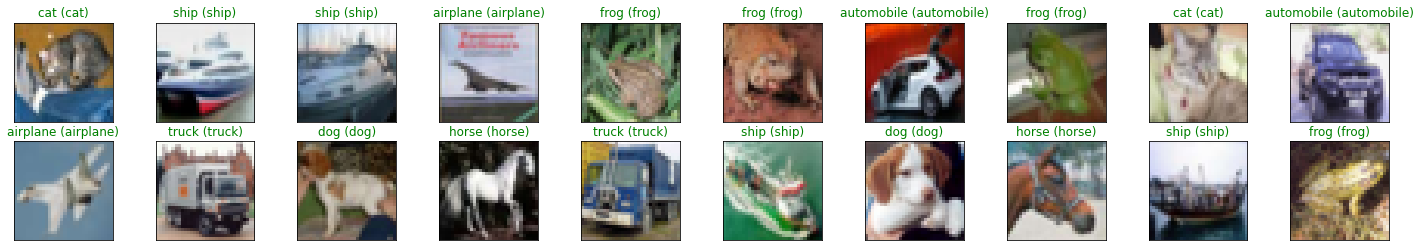

In [32]:
images,labels = next(iter(test_loader))

if train_on_gpu:
  images = images.cuda()

output = model(images)

_, pred_tensor = torch.max(output,1)

if train_on_gpu: preds = np.squeeze(pred_tensor.cpu().numpy()) 
else: preds = np.squeeze(pred_tensor.numpy())

display_batch_test_images(preds,images,classes)